In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, 
                             roc_auc_score, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay,
                             RocCurveDisplay,
                             precision_recall_curve,
                             PrecisionRecallDisplay)
from sklearn.calibration import CalibrationDisplay

# 设置绘图风格
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (10, 6)

## 1. 数据探索

数据预览：


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Data information：
shape: (7043, 21)
feature number: 20
Sample size: 7043

missing values：
NO MISSING VALUES！
处理前缺失值数量: 11
处理后缺失值数量: 0


C:\Users\Honor\AppData\Local\Temp\ipykernel_9296\3805710641.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["MonthlyCharges"], inplace=True)
C:\Users\Honor\AppData\Local\Temp\ipykernel_9296\3805710641.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="viridis")


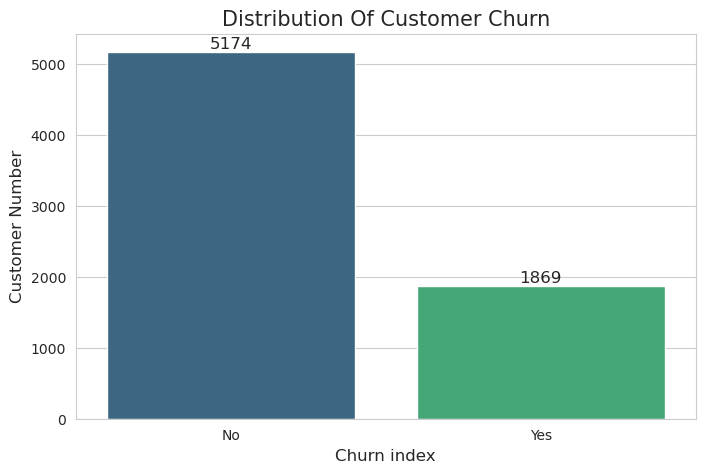

Churn Ratio: 26.54%


C:\Users\Honor\AppData\Local\Temp\ipykernel_9296\3805710641.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Churn Ratio: {churn_counts[1]/churn_counts.sum():.2%}")


In [4]:

df = pd.read_csv("telecom_churn.csv")


print("数据预览：")
display(df.head())


print("\nData information：")
print(f"shape: {df.shape}")
print(f"feature number: {df.shape[1]-1}")  # 减去目标变量
print(f"Sample size: {df.shape[0]}")


# 检查缺失值
print("\nmissing values：")
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
if missing_data.empty:
    print("NO MISSING VALUES！")
else:
    print(missing_data)


# 处理TotalCharges中的缺失值
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
print(f"处理前缺失值数量: {df['TotalCharges'].isnull().sum()}")

# 用MonthlyCharges填充缺失的TotalCharges
df["TotalCharges"].fillna(df["MonthlyCharges"], inplace=True)
print(f"处理后缺失值数量: {df['TotalCharges'].isnull().sum()}")


# 目标变量分布
plt.figure(figsize=(8, 5))
churn_counts = df["Churn"].value_counts()
ax = sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="viridis")
plt.title("Distribution Of Customer Churn", fontsize=15)
plt.xlabel("Churn index", fontsize=12)
plt.ylabel("Customer Number", fontsize=12)

# 添加数值标签
for i, v in enumerate(churn_counts.values):
    ax.text(i, v + 50, str(v), ha='center', fontsize=12)
    
plt.show()

print(f"Churn Ratio: {churn_counts[1]/churn_counts.sum():.2%}")

## 2. 特征工程

In [5]:



# 定义特征类型
numerical_features = ["tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = ["gender", "SeniorCitizen", "Partner", "Dependents", 
                        "PhoneService", "MultipleLines", "InternetService",
                        "OnlineSecurity", "OnlineBackup", "DeviceProtection",
                        "TechSupport", "StreamingTV", "StreamingMovies",
                        "Contract", "PaperlessBilling", "PaymentMethod"]

# 创建预处理管道
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features)
    ])

# 提取特征和目标
X = df.drop("Churn", axis=1)
y = df["Churn"].map({"Yes": 1, "No": 0})  # 转换为二进制

# 获取特征名称
preprocessor.fit(X)
num_feature_names = numerical_features
cat_feature_names = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

print(f"原始特征数量: {X.shape[1]}")
print(f"转换后特征数量: {len(all_feature_names)}")

原始特征数量: 20
转换后特征数量: 30


## 4. 划分训练集和测试集

In [6]:


# %%
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"训练集大小: {X_train.shape[0]} 样本")
print(f"测试集大小: {X_test.shape[0]} 样本")
print(f"训练集流失比例: {y_train.mean():.2%}")
print(f"测试集流失比例: {y_test.mean():.2%}")



训练集大小: 5634 样本
测试集大小: 1409 样本
训练集流失比例: 26.54%
测试集流失比例: 26.54%


## 5. 构建逻辑回归模型

In [7]:


# %%
# 创建模型管道
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        class_weight="balanced",  # 处理样本不平衡
        max_iter=1000,
        random_state=42,
        solver="liblinear"  # 支持L1/L2正则化
    ))
])

# 训练模型
model.fit(X_train, y_train)

print("模型训练完成！")



模型训练完成！


## 6. 模型评估

分类报告：
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

AUC分数: 0.8419


D:\andconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26410 (\N{CJK UNIFIED IDEOGRAPH-672A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\andconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27969 (\N{CJK UNIFIED IDEOGRAPH-6D41}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\andconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\andconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\andconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\andconda\Lib\site

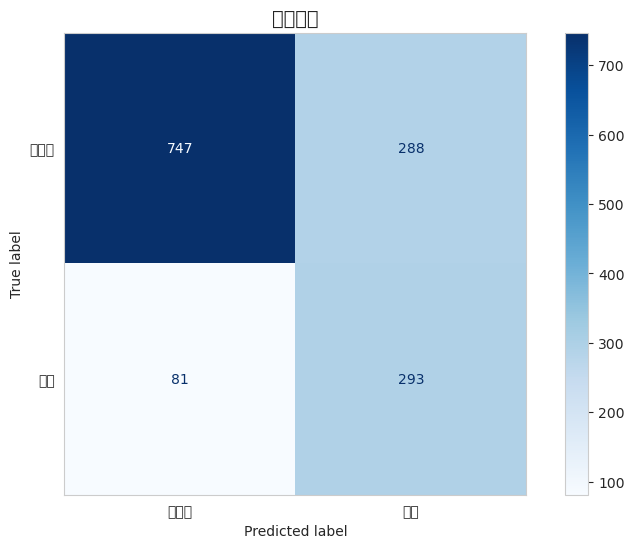

D:\andconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\andconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


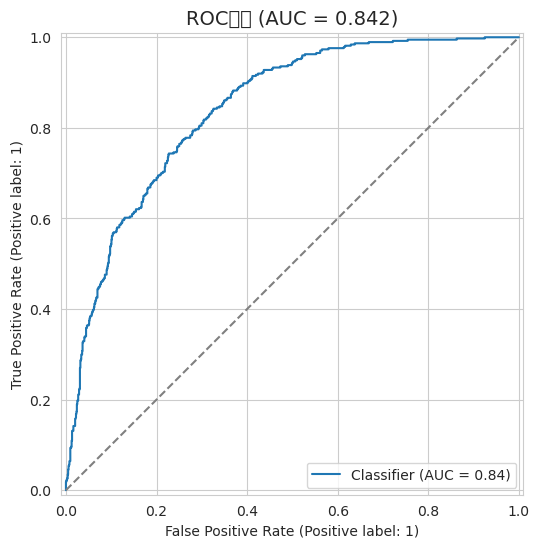

D:\andconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31934 (\N{CJK UNIFIED IDEOGRAPH-7CBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\andconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\andconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\andconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21484 (\N{CJK UNIFIED IDEOGRAPH-53EC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\andconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\andconda\Lib\site

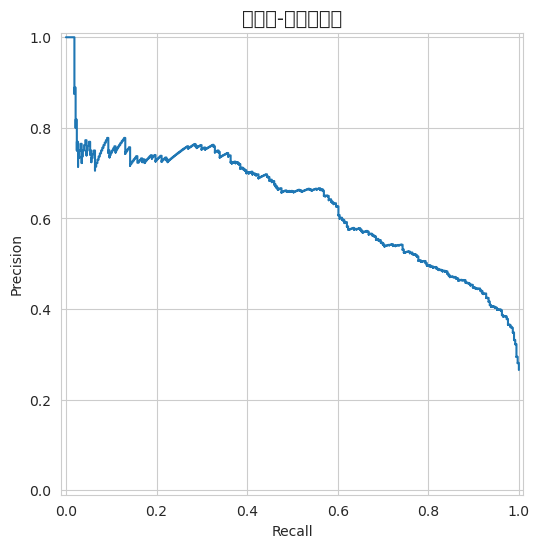

D:\andconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27010 (\N{CJK UNIFIED IDEOGRAPH-6982}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\andconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\andconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26657 (\N{CJK UNIFIED IDEOGRAPH-6821}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\andconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\andconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\andconda\Lib\site

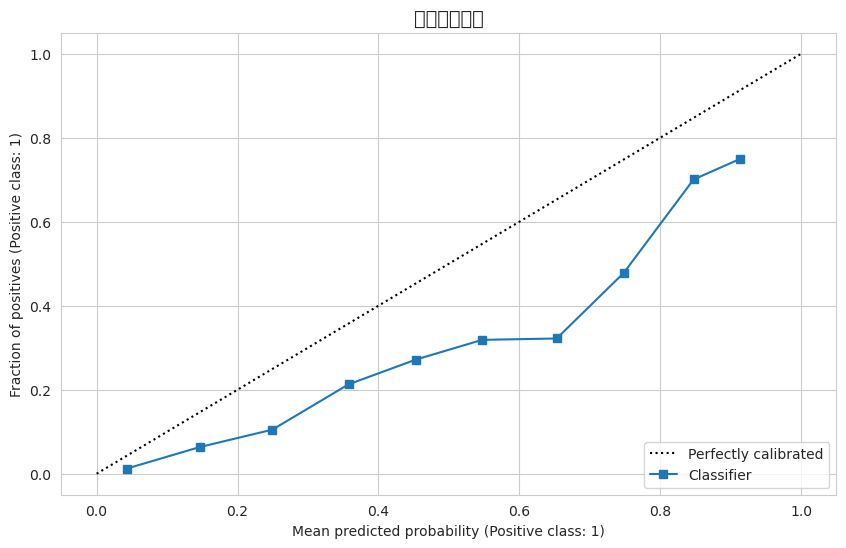

In [9]:



# %%
# 预测结果
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # 预测概率

# %%
# 分类报告
print("分类报告：")
print(classification_report(y_test, y_pred))

# %%
# AUC分数
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC分数: {auc_score:.4f}")

# %%
# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["未流失", "流失"])
disp.plot(cmap="Blues")
plt.title("混淆矩阵", fontsize=14)
plt.grid(False)
plt.show()

# %%
# ROC曲线
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC曲线 (AUC = {:.3f})".format(auc_score), fontsize=14)
plt.show()

# %%
# 精确率-召回率曲线
precision, recall, _ = precision_recall_curve(y_test, y_proba)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("精确率-召回率曲线", fontsize=14)
plt.show()

# %%
# 校准曲线
CalibrationDisplay.from_predictions(y_test, y_proba, n_bins=10)
plt.title("概率校准曲线", fontsize=14)
plt.show()

特征重要性（前20个）：


,特征,系数,影响大小
25,Contract_Two year,-1.414481,1.414481
0,tenure,-1.156252,1.156252
10,InternetService_Fiber optic,1.117195,1.117195
24,Contract_One year,-0.720367,0.720367
2,TotalCharges,0.489136,0.489136
1,MonthlyCharges,-0.424486,0.424486
7,PhoneService_Yes,-0.401349,0.401349
28,PaymentMethod_Electronic check,0.397194,0.397194
23,StreamingMovies_Yes,0.380316,0.380316
13,OnlineSecurity_Yes,-0.356042,0.356042


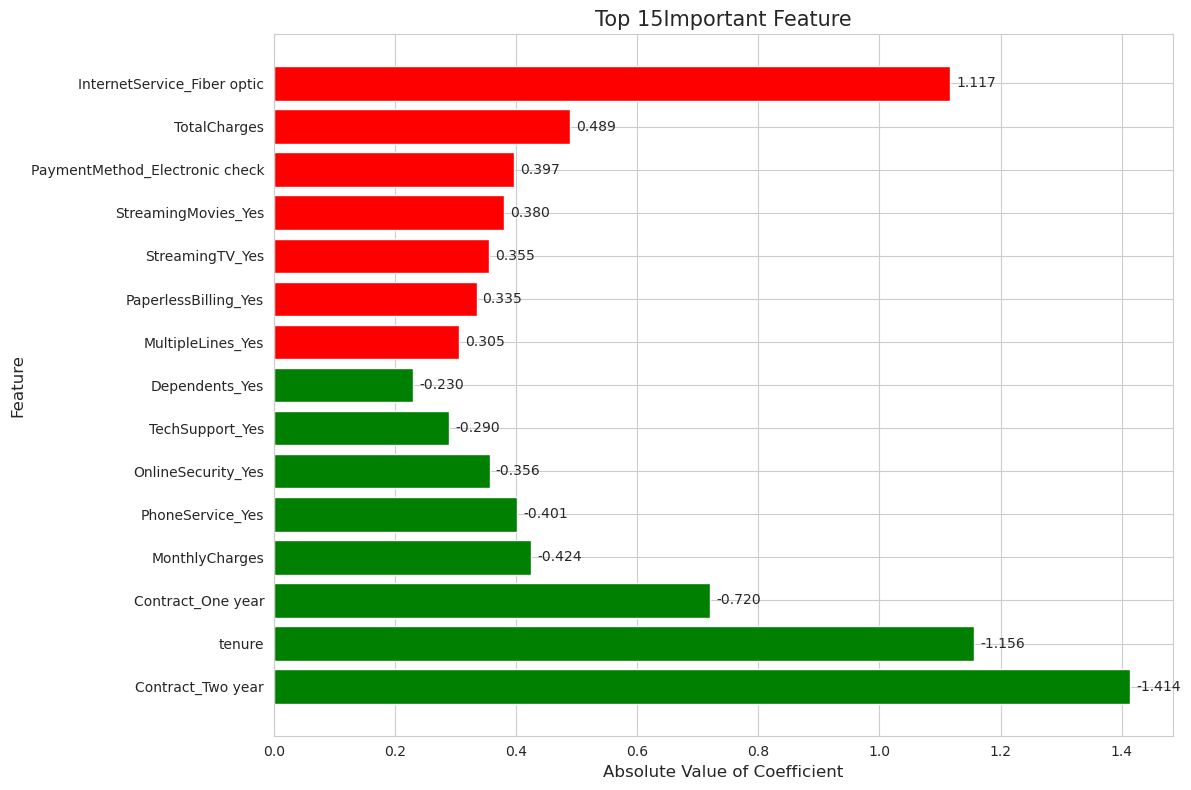

In [11]:
# %% [markdown]
# ## 7. 特征重要性分析

# %%
# 获取系数
coefficients = model.named_steps["classifier"].coef_[0]

# 创建特征重要性DataFrame
feature_importance = pd.DataFrame({
    "特征": all_feature_names,
    "系数": coefficients,
    "影响大小": np.abs(coefficients)
}).sort_values("影响大小", ascending=False)

# 显示前20个特征
print("特征重要性（前20个）：")
display(feature_importance.head(20))

# %%
# 可视化特征重要性（前15个）
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15).sort_values("系数", ascending=True)
colors = ["red" if coef > 0 else "green" for coef in top_features["系数"]]
plt.barh(top_features["特征"], top_features["影响大小"], color=colors)
plt.xlabel("Absolute Value of Coefficient", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Top 15Important Feature", fontsize=15)
plt.axvline(x=0, color="black", linestyle="--", alpha=0.3)

# 添加系数值标签
for i, (coef, impact) in enumerate(zip(top_features["系数"], top_features["影响大小"])):
    plt.text(impact + 0.01, i, f"{coef:.3f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [12]:
# %% [markdown]
# ## 8. 模型优化（网格搜索）

# %%
# 定义超参数网格
param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10],  # 正则化强度
    "classifier__penalty": ["l1", "l2"],    # 正则化类型
    "classifier__solver": ["liblinear"]      # 优化算法
}

# 网格搜索
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,                   # 5折交叉验证
    scoring="roc_auc",       # 使用AUC作为评估指标
    n_jobs=-1,              # 使用所有CPU核心
    verbose=1
)

# 执行网格搜索
print("开始网格搜索...")
grid_search.fit(X_train, y_train)
print("网格搜索完成！")

# %%
# 显示最佳参数
print("最佳参数组合:")
print(grid_search.best_params_)
print(f"最佳AUC分数: {grid_search.best_score_:.4f}")

# %%
# 获取最佳模型
best_model = grid_search.best_estimator_

# 在测试集上评估最佳模型
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

# 分类报告
print("优化后模型分类报告：")
print(classification_report(y_test, y_pred_best))

# AUC分数
auc_score_best = roc_auc_score(y_test, y_proba_best)
print(f"优化后AUC分数: {auc_score_best:.4f}")


开始网格搜索...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
网格搜索完成！
最佳参数组合:
{'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
最佳AUC分数: 0.8456
优化后模型分类报告：
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

优化后AUC分数: 0.8409


## 9. 业务解读与建议

In [13]:

# %%
# 获取最佳模型的系数
best_coefficients = best_model.named_steps["classifier"].coef_[0]

# 创建特征重要性DataFrame
best_feature_importance = pd.DataFrame({
    "特征": all_feature_names,
    "系数": best_coefficients,
    "影响大小": np.abs(best_coefficients)
}).sort_values("影响大小", ascending=False)

# 提取高风险和保护性特征
high_risk_features = best_feature_importance[best_feature_importance["系数"] > 0].head(5)
protective_features = best_feature_importance[best_feature_importance["系数"] < 0].head(5)

# %%
print("高风险特征（增加流失概率）：")
display(high_risk_features)

print("\n保护性特征（减少流失概率）：")
display(protective_features)

# %%
# 业务建议
print("\n业务建议：")
print("1. 高风险客户干预策略：")
for _, row in high_risk_features.iterrows():
    feature = row["特征"]
    coef = row["系数"]
    print(f"   - {feature} (风险系数: {coef:.3f}):")
    if "Contract" in feature:
        print("      * 提供长期合同优惠，如年付折扣")
    elif "InternetService" in feature:
        print("      * 优化光纤服务质量或提供增值服务")
    elif "PaperlessBilling" in feature:
        print("      * 提供纸质账单选项或账单提醒服务")
    else:
        print("      * 分析具体原因并设计针对性保留方案")

print("\n2. 客户保留增强策略：")
for _, row in protective_features.iterrows():
    feature = row["特征"]
    coef = row["系数"]
    print(f"   - {feature} (保护系数: {coef:.3f}):")
    if "tenure" in feature:
        print("      * 设计忠诚度计划奖励长期客户")
    elif "OnlineSecurity" in feature or "TechSupport" in feature:
        print("      * 为新客户提供免费试用期")
    elif "Contract" in feature:
        print("      * 推广长期合同优势")
    else:
        print("      * 强化该服务的市场推广")


高风险特征（增加流失概率）：


,特征,系数,影响大小
10,InternetService_Fiber optic,2.387300,2.387300
23,StreamingMovies_Yes,0.886298,0.886298
21,StreamingTV_Yes,0.860971,0.860971
9,MultipleLines_Yes,0.558191,0.558191
2,TotalCharges,0.522081,0.522081



保护性特征（减少流失概率）：


,特征,系数,影响大小
1,MonthlyCharges,-1.956628,1.956628
25,Contract_Two year,-1.447866,1.447866
8,MultipleLines_No phone service,-1.272066,1.272066
0,tenure,-1.185025,1.185025
14,OnlineBackup_No internet service,-1.036339,1.036339



业务建议：
1. 高风险客户干预策略：
   - InternetService_Fiber optic (风险系数: 2.387):
      * 优化光纤服务质量或提供增值服务
   - StreamingMovies_Yes (风险系数: 0.886):
      * 分析具体原因并设计针对性保留方案
   - StreamingTV_Yes (风险系数: 0.861):
      * 分析具体原因并设计针对性保留方案
   - MultipleLines_Yes (风险系数: 0.558):
      * 分析具体原因并设计针对性保留方案
   - TotalCharges (风险系数: 0.522):
      * 分析具体原因并设计针对性保留方案

2. 客户保留增强策略：
   - MonthlyCharges (保护系数: -1.957):
      * 强化该服务的市场推广
   - Contract_Two year (保护系数: -1.448):
      * 推广长期合同优势
   - MultipleLines_No phone service (保护系数: -1.272):
      * 强化该服务的市场推广
   - tenure (保护系数: -1.185):
      * 设计忠诚度计划奖励长期客户
   - OnlineBackup_No internet service (保护系数: -1.036):
      * 强化该服务的市场推广


## 10. 模型部署准备

In [14]:

# %%
# 保存最佳模型
import joblib

# 保存模型
joblib.dump(best_model, "churn_prediction_model.pkl")

# 保存特征名称
joblib.dump(all_feature_names, "feature_names.pkl")

print("模型和特征名称已保存！")

# %%
# 创建部署示例函数
def predict_churn(customer_data):
    """
    预测客户流失概率
    
    参数:
    customer_data (dict): 包含客户特征的字典
    
    返回:
    dict: 包含预测结果和解释的字典
    """
    # 创建DataFrame
    input_df = pd.DataFrame([customer_data])
    
    # 加载模型
    model = joblib.load("churn_prediction_model.pkl")
    
    # 预测概率
    proba = model.predict_proba(input_df)[0][1]
    
    # 获取特征重要性
    coefficients = model.named_steps["classifier"].coef_[0]
    feature_names = joblib.load("feature_names.pkl")
    
    # 创建特征贡献字典
    feature_contributions = {}
    for name, coef in zip(feature_names, coefficients):
        # 只考虑当前客户存在的特征
        if name in input_df.columns or name.split("_")[0] in input_df.columns:
            # 这里简化处理，实际应用中需要更复杂的逻辑
            feature_contributions[name] = coef
    
    # 返回结果
    return {
        "churn_probability": proba,
        "prediction": "高风险" if proba > 0.5 else "低风险",
        "feature_contributions": feature_contributions
    }

# 测试预测函数
sample_customer = {
    "tenure": 12,
    "MonthlyCharges": 80.5,
    "TotalCharges": 965.0,
    "gender": "Male",
    "SeniorCitizen": 0,
    "Partner": "Yes",
    "Dependents": "No",
    "PhoneService": "Yes",
    "MultipleLines": "Yes",
    "InternetService": "Fiber optic",
    "OnlineSecurity": "No",
    "OnlineBackup": "No",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "Yes",
    "StreamingMovies": "Yes",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check"
}

print("示例客户预测结果：")
print(predict_churn(sample_customer))




模型和特征名称已保存！
示例客户预测结果：
{'churn_probability': 0.9594450887372882, 'prediction': '高风险', 'feature_contributions': {'tenure': -1.18502518385777, 'MonthlyCharges': -1.9566275426015736, 'TotalCharges': 0.5220807919623176, 'gender_Male': 0.03244934533464317, 'SeniorCitizen_1': 0.15443395198249377, 'Partner_Yes': 0.016679956954504336, 'Dependents_Yes': -0.22872664980443982, 'PhoneService_Yes': -0.5104401799561706, 'MultipleLines_No phone service': -1.272065978742322, 'MultipleLines_Yes': 0.5581908043171374, 'InternetService_Fiber optic': 2.3872996664853874, 'InternetService_No': -0.3064551483854615, 'OnlineSecurity_No internet service': -0.1608734661738523, 'OnlineSecurity_Yes': -0.10149700689017804, 'OnlineBackup_No internet service': -1.0363391892474563, 'OnlineBackup_Yes': 0.15752319389492322, 'DeviceProtection_No internet service': -0.19982103505254523, 'DeviceProtection_Yes': 0.2719720767605663, 'TechSupport_No internet service': -0.41217484195641796, 'TechSupport_Yes': -0.0318937769674060